# SimpleRnnlm, LSTMlm, GRUlmを用いて学習を行う
* 次の単語を予測する問題を解いてみる
* SimpleRnnlm, LSTMlm, GRUlmは、modelで切り替えられる

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD, Adam
from dataset import ptb
from common.simple_rnnlm import SimpleRnnlm
from common.lstmlm import LSTMlm
from common.grulm import GRUlm

In [2]:
# %演算子の確認
# %演算子は余りを返す
print(  99%100)
print(100%100)
print(101%100)
print(151%100)
print(201%100)

99
0
1
51
1


### 学習データの読み込み
* 学習用データには、英語コーパスであるPenn Treebankを用いる。
* 全ての文章を1つの系列に結合し、1つの時系列として扱うことにする。
* 1単語が1時刻になる。
* ある単語の次にくる単語を予測できるように学習を行う。
* ここで利用するPenn Treebankでは、以下の前処理が施されている。
    * 出現頻度が少ない単語は$<unk>$に置き換えられている。
    * 具体的な数字がNに置き換えられている。
    * 全ての文は繋がっており、文の切れ目に$<eos>$という単語が入っている。

In [3]:
corpus, word_to_id, id_to_word = ptb.load_data(data_type='train')
print("単語数=", len(corpus))
print("corpus=", corpus)  # 単語IDの配列
print("word_to_id=", word_to_id) # 単語名がkeyで単語IDがvalueのdict
print("id_to_word=", id_to_word) # 単語IDがkeyで単語名がvalueのdict

単語数= 929589
corpus= [ 0  1  2 ... 39 26 24]
word_to_id= {'aer': 0, 'banknote': 1, 'berlitz': 2, 'calloway': 3, 'centrust': 4, 'cluett': 5, 'fromstein': 6, 'gitano': 7, 'guterman': 8, 'hydro-quebec': 9, 'ipo': 10, 'kia': 11, 'memotec': 12, 'mlx': 13, 'nahb': 14, 'punts': 15, 'rake': 16, 'regatta': 17, 'rubens': 18, 'sim': 19, 'snack-food': 20, 'ssangyong': 21, 'swapo': 22, 'wachter': 23, '<eos>': 24, 'pierre': 25, '<unk>': 26, 'N': 27, 'years': 28, 'old': 29, 'will': 30, 'join': 31, 'the': 32, 'board': 33, 'as': 34, 'a': 35, 'nonexecutive': 36, 'director': 37, 'nov.': 38, 'mr.': 39, 'is': 40, 'chairman': 41, 'of': 42, 'n.v.': 43, 'dutch': 44, 'publishing': 45, 'group': 46, 'rudolph': 47, 'and': 48, 'former': 49, 'consolidated': 50, 'gold': 51, 'fields': 52, 'plc': 53, 'was': 54, 'named': 55, 'this': 56, 'british': 57, 'industrial': 58, 'conglomerate': 59, 'form': 60, 'asbestos': 61, 'once': 62, 'used': 63, 'to': 64, 'make': 65, 'kent': 66, 'cigarette': 67, 'filters': 68, 'has': 69, 'cau

## テストデータの読み込み

### 計算条件の設定

In [4]:
# ハイパーパラメータの設定
batch_size = 20 # バッチサイズ
wordvec_size = 100 # 単語埋め込みベクトルの要素数
hidden_size = 100 # RNNレイヤのノード数
time_size = 20  # 文章を区切る時間数. 全ての文章を1つの系列に結合したものをtime_sizeで区切りミニバッチを生成する
lr = 0.001 # 学習率
epochs = 100 # エポックス数

### 学習用データとテスト用データをつくる
学習用データを全て使うと計算に時間がかかるので、データセットを小さくする

In [5]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 10000
corpus = corpus[:corpus_size] # データセットを小さくする
vocab_size = int(max(corpus) + 1) # 単語IDの最大値から語彙数の大きさを決める
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習用とテスト用にわける
corpus_train_size = 9000
corpus_train = corpus[:corpus_train_size] # 学習用の単語を抜き出す
corpus_test = corpus[corpus_train_size:] # テスト用の単語を抜き出す

corpus size: 10000, vocabulary size: 2138


In [6]:
xs = corpus_train[:-1]  # 入力データ. 1時刻先を予測するので、最後の単語は使わない
ts = corpus_train[1:]  # 正解データ（教師ラベル）. 1時刻先を予測するので、最初の単語は使わない

data_size = len(xs)

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ave_loss_list = []

# オブジェクトの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
# model = LSTMlm(vocab_size, wordvec_size, hidden_size)
# model = GRUlm(vocab_size, wordvec_size, hidden_size)

# 最適化手法の定義
optimizer = Adam(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]
print("offsets=", offsets)

# 学習
for epoch in range(epochs):
    """
    epochのループ
    """
    
    for m in range(max_iters):
        """
        ミニバッチのループ
        """
        
        # ミニバッチを生成
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size] # %演算子 : 余りを返す. 
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t) # 順伝播計算
        model.backward() # 逆伝播計算
        optimizer.update(model.params, model.grads) # パラメータの更新
        total_loss += loss # ロスの追加
        loss_count += 1

    # 平均損失の算出
    ave_loss = total_loss / loss_count
    print('| epoch %d | averaged loss %.4f'% (epoch+1, ave_loss))
    ave_loss_list.append(float(ave_loss))
    total_loss, loss_count = 0, 0


offsets= [0, 499, 998, 1497, 1996, 2495, 2994, 3493, 3992, 4491, 4990, 5489, 5988, 6487, 6986, 7485, 7984, 8483, 8982, 9481]
| epoch 1 | averaged loss 7.3822
| epoch 2 | averaged loss 6.3033
| epoch 3 | averaged loss 6.0878
| epoch 4 | averaged loss 6.0543
| epoch 5 | averaged loss 6.0448
| epoch 6 | averaged loss 6.0495
| epoch 7 | averaged loss 6.0309
| epoch 8 | averaged loss 5.9900
| epoch 9 | averaged loss 5.9392
| epoch 10 | averaged loss 5.8434
| epoch 11 | averaged loss 5.7421
| epoch 12 | averaged loss 5.6624
| epoch 13 | averaged loss 5.5156
| epoch 14 | averaged loss 5.4133
| epoch 15 | averaged loss 5.3901
| epoch 16 | averaged loss 5.6288
| epoch 17 | averaged loss 5.2535
| epoch 18 | averaged loss 5.1111
| epoch 19 | averaged loss 5.0116
| epoch 20 | averaged loss 4.9567
| epoch 21 | averaged loss 4.8595
| epoch 22 | averaged loss 4.7652
| epoch 23 | averaged loss 4.6960
| epoch 24 | averaged loss 4.6041
| epoch 25 | averaged loss 4.5401
| epoch 26 | averaged loss 4.4546


### グラフの描画

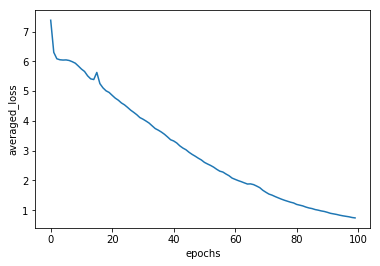

In [7]:
x = np.arange(len(ave_loss_list))
plt.plot(x, ave_loss_list, label='train')
plt.xlabel('epochs')
plt.ylabel('averaged_loss')
plt.show()

### 単語の予測
* 学習が十分でなく、予測精度が低いので、おもしろい結果にはならない

In [8]:
batch_size_test = 100 # バッチサイズ
xs = corpus_test[:-1]#.reshape(-1,1)  # 入力. 1時刻先を予測するので、最後の単語は使わない
ts = corpus_test[1:]#.reshape(-1,1)  # 出力（教師ラベル）. 1時刻先を予測するので、最初の単語は使わない

# ミニバッチの各サンプルの読み込み開始位置を計算
# batch_size = 100
jump = (len(corpus_test) - 1) // batch_size_test
offsets = [i * jump for i in range(batch_size_test)]
print("offsets=", offsets)

# ミニバッチを生成
batch_test_x = np.empty((batch_size_test, time_size), dtype='i')
batch_test_t = np.empty((batch_size_test, time_size), dtype='i')
time_idx = 0
for t in range(time_size):
    for i, offset in enumerate(offsets):
        batch_test_x[i, t] = xs[(offset+time_idx) % data_size] # %演算子 : 余りを返す. ただし、1未満の場合は分子を返す
        batch_test_t[i, t] = ts[(offset+time_idx) % data_size]
    time_idx += 1
    
# 次にくる単語を予測する
model.layers[1].stateful = False # TimeRNNレイヤの中間状態hを初期化する
activations = model.predict(batch_test_x)
batch_test_p = np.argmax(activations, axis=2)

# 各バッチの最終列(単語index)だけを取り出す
xs = batch_test_x[:, -1]
ts = batch_test_t[:,-1]
ps = batch_test_p[:, -1]

# 単語indexを単語に変換する
word_xs = [id_to_word[i] for i in xs]
word_ts = [id_to_word[i] for i in ts]
word_ps = [id_to_word[i] for i in ps]

df = pd.DataFrame()
df["入力単語"] = word_xs
df["正解単語"] = word_ts
df["予測単語"] = word_ps
df

offsets= [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 189, 198, 207, 216, 225, 234, 243, 252, 261, 270, 279, 288, 297, 306, 315, 324, 333, 342, 351, 360, 369, 378, 387, 396, 405, 414, 423, 432, 441, 450, 459, 468, 477, 486, 495, 504, 513, 522, 531, 540, 549, 558, 567, 576, 585, 594, 603, 612, 621, 630, 639, 648, 657, 666, 675, 684, 693, 702, 711, 720, 729, 738, 747, 756, 765, 774, 783, 792, 801, 810, 819, 828, 837, 846, 855, 864, 873, 882, 891]


,入力単語,正解単語,予測単語
0,would,have,studied
1,range,for,<eos>
2,of,recession,N
3,the,nation,commission
4,be,slowing,eligible
5,managers,reported,however
6,N,N,categories
7,export,orders,as
8,N,the,from
9,report,also,<eos>


### 埋め込み行列の表示

In [9]:
Win = model.layers[0].params[0]
print(Win.shape, "\n")
print("Win=", Win)

(2138, 100) 

Win= [[-0.20370554 -0.15579178 -0.12784733 ...  0.19645299  0.07932719
   0.16107322]
 [-0.04962133 -0.16110307 -0.04499471 ...  0.16960392 -0.23869045
  -0.13704354]
 [-0.11949371 -0.06488445  0.04175254 ...  0.0011227   0.07087085
   0.16610735]
 ...
 [ 0.00125825  0.01033511  0.01162728 ... -0.02044955 -0.00693247
   0.0149326 ]
 [ 0.0061079  -0.00041564  0.00474694 ...  0.00337638  0.00357565
   0.00553826]
 [ 0.00417825 -0.00496415 -0.01760532 ... -0.00582272  0.00172562
   0.00401181]]
